## EDA for Task 2: NER + Image Classification

## Part 1: Images EDA

In this part we work with downloaded [Animal-10](https://www.kaggle.com/datasets/alessiocorrado99/animals10?select=raw-img) dataset from Kaggle. This dataset consists of pictures of 10 different animals. Dataset is divided into 10 folders, each folder represents 1 class.

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import numpy as np
import random
import spacy

from PIL import Image
from pathlib import Path
from wordcloud import WordCloud

In [2]:
def convert_img_to_df(dataset):
    extensions = ["jpg", "jpeg", "png", "JPG", "JPEG", "PNG"]
    filepaths = [str(path) for ext in extensions for path in Path(dataset).rglob(f"*.{ext}")]

    labels = [os.path.basename(os.path.dirname(path)) for path in filepaths]
    return pd.DataFrame({"filepath": filepaths, "label": labels})

In [3]:
df = convert_img_to_df("data/image_dataset/")
df.head()

,filepath,label
0,data\image_dataset\butterfly\e030b20928e90021d...,butterfly
1,data\image_dataset\butterfly\e030b20929e90021d...,butterfly
2,data\image_dataset\butterfly\e030b2092be90021d...,butterfly
3,data\image_dataset\butterfly\e030b2092ce90021d...,butterfly
4,data\image_dataset\butterfly\e030b2092de90021d...,butterfly


Now let's explore label distribution in dataset

In [4]:
df_count = df['label'].value_counts()
df_count

label
dog          9726
spider       9642
chicken      6196
horse        5246
butterfly    4224
cow          3732
squirrel     3724
sheep        3640
cat          3336
elephant     2892
Name: count, dtype: int64

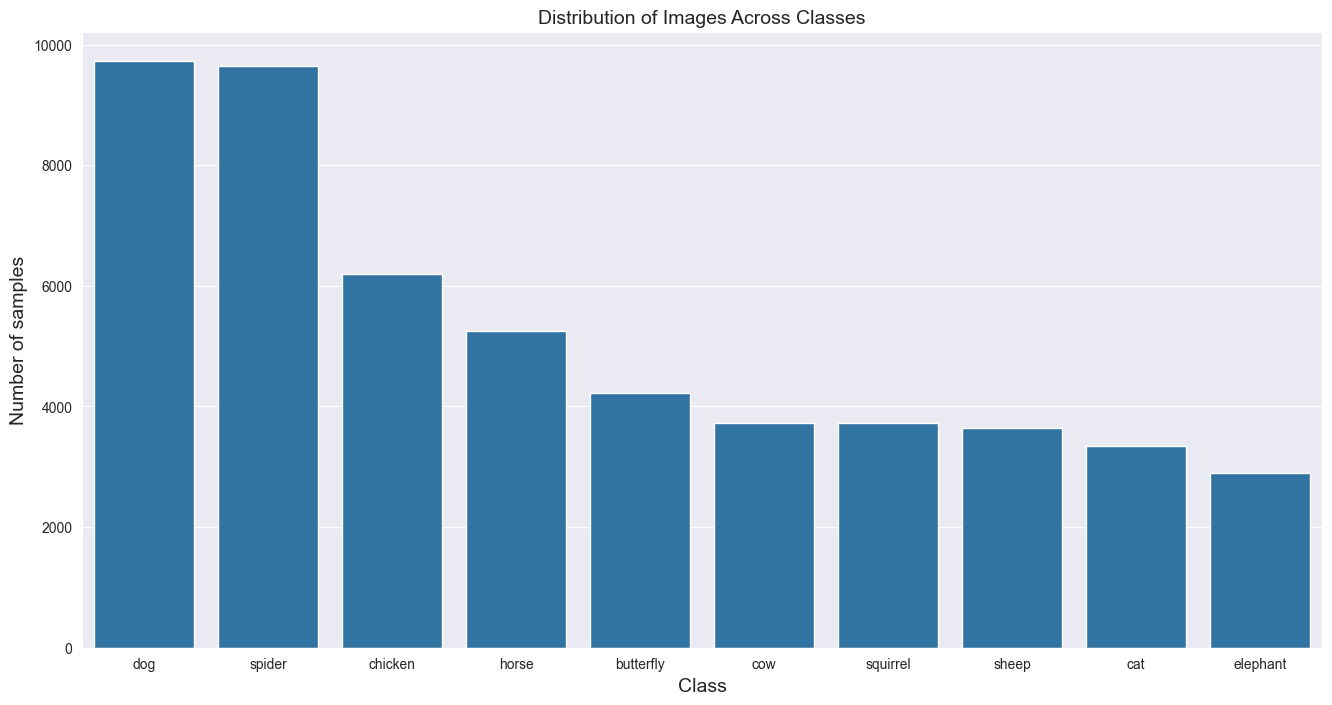

In [5]:
fig , axes = plt.subplots(figsize = (16 , 8))

sns.barplot(x=df_count.index, y=df_count.values )
axes.set_title('Distribution of Images Across Classes' , fontsize = 14)
axes.set_xlabel('Class' , fontsize = 14)
axes.set_ylabel('Number of samples' , fontsize = 14)
plt.show()

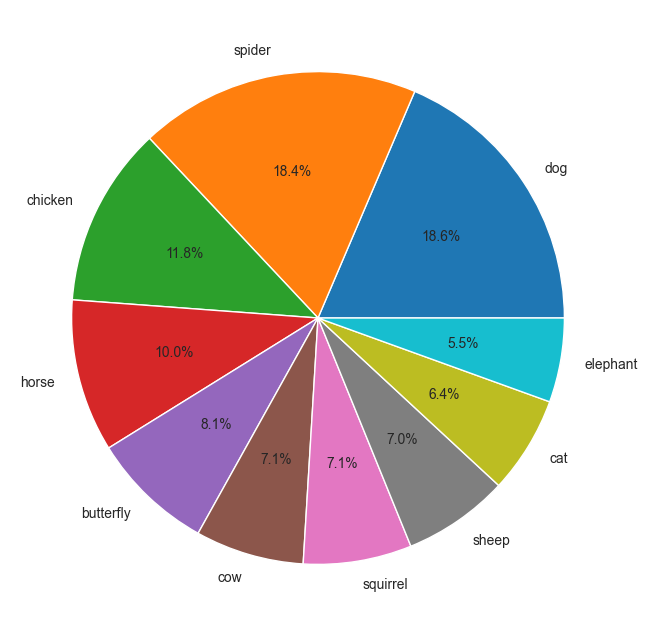

In [6]:
plt.figure(figsize = (20 , 8))
plt.pie( df_count.values  , labels = df_count.index ,  autopct = '%.1f%%'   )
plt.show()

We can see that there is some class imbalance. But it isn't critical, we will be able to compensate for it in the future with the help of architectural features or by setting weights.

Let's visualize some samples.

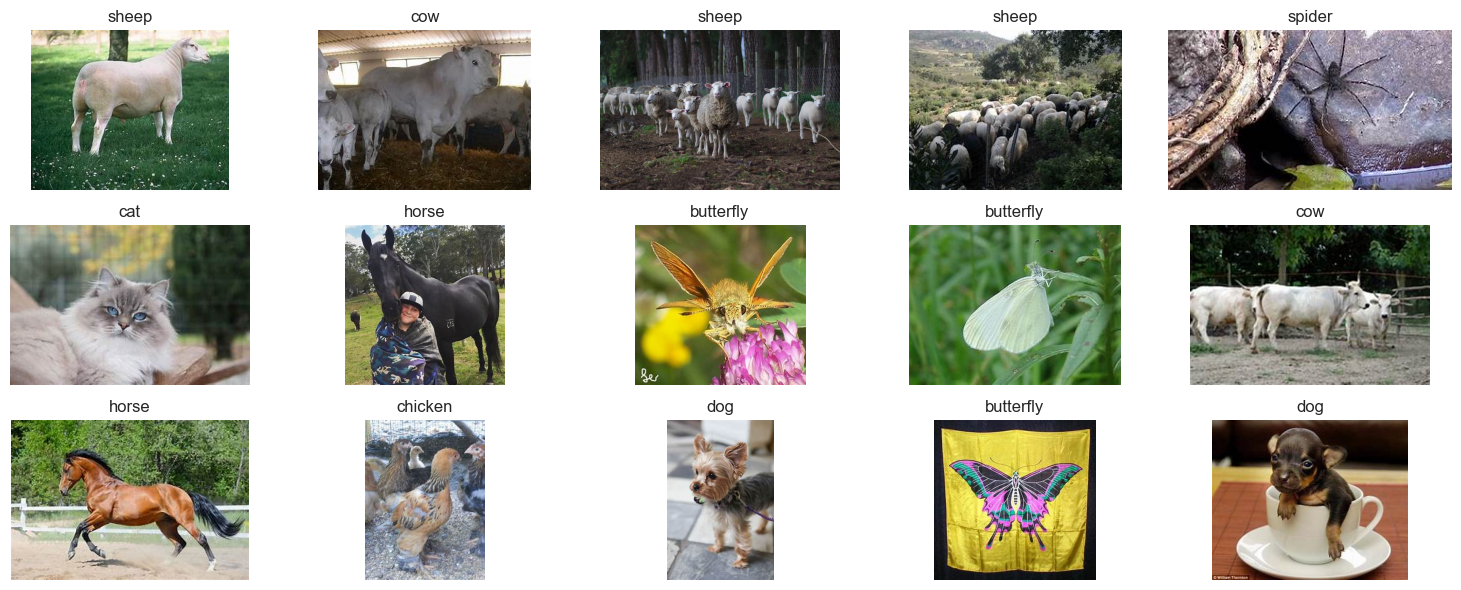

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 6))
axes = axes.ravel()

# Randomly select 15 rows from the dataframe
for i, (_, row) in enumerate(df.sample(n=15).iterrows()):
    img_path = row["filepath"]
    label = row["label"]

    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].set_title(label)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

As we can see, our images have different size. For image classification we will use some deep learning models which expect images with exactly same sizes. So let's check our images distribution to determine size, which will be the tradeoff between memory and quality.

In [8]:
image_sizes = []

for img_path in random.sample(df["filepath"].tolist(), min(100, len(df))):
    try:
        img = Image.open(img_path)
        image_sizes.append(img.size)
    except Exception as e:
        print(f"Corrupted image: {img_path} ({e})")

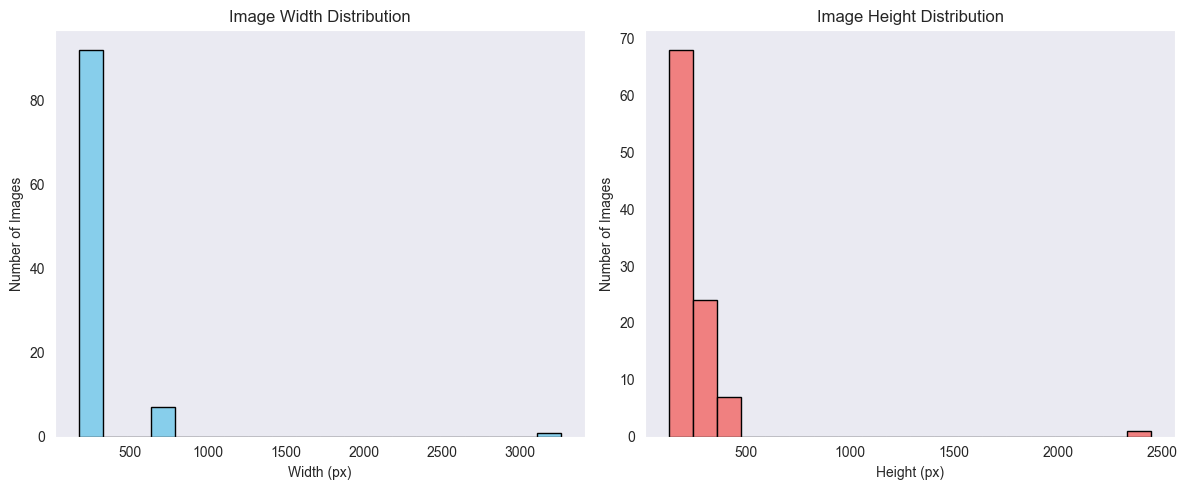

In [9]:
widths, heights = zip(*image_sizes)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histogram for width distribution
axes[0].hist(widths, bins=20, color="skyblue", edgecolor="black")
axes[0].set_title("Image Width Distribution")
axes[0].set_xlabel("Width (px)")
axes[0].set_ylabel("Number of Images")
axes[0].grid(False)

# Histogram for height distribution
axes[1].hist(heights, bins=20, color="lightcoral", edgecolor="black")
axes[1].set_title("Image Height Distribution")
axes[1].set_xlabel("Height (px)")
axes[1].set_ylabel("Number of Images")
axes[1].grid(False)

plt.tight_layout()
plt.show()

It would be better for us to resize images to 224 * 224 size, but we will do this kind of data manipulation in the saparate file.

## Part 2: EDA for NER

In this part we create our own dataset for NER task in animals category.

I chose the following strategy: I'll take the labels I have for animal names and use ChatGPT to get more animal names.

In [11]:
df['label'].unique()

array(['butterfly', 'cat', 'elephant', 'sheep', 'spider', 'chicken',
       'cow', 'dog', 'horse', 'squirrel'], dtype=object)

That is how my animals names looks like:

In [18]:
file_path = r"data\NER_data\animals_names.txt"

with open(file_path, "r", encoding="utf-8") as file:
    lines = file.readlines()

print(f'Number of different animals: {len(lines)}')
for line in lines[10:20]:
    print(line.strip())

Number of different animals: 58
- wolf
- fox
- deer
- giraffe
- kangaroo
- rabbit
- monkey
- zebra
- bison
- chicken


After that, I created a ChatGPT prompt template like:
``` bash
Your task is to generate sentences with mentioning the animals that I will list at the end of the prompt.
 Here are examples:
- The {animal} is standing near the tree.
- A {animal} is grazing in the field, enjoying the fresh grass.
- The {animal} appears to be curious, peeking through the fence.
- The {animal} looks content, sitting by the edge of the pond, watching the water.

But your otput should be in mardown format and look like this:
- The {animal} is standing near the tree. -> "The {animal} is standing near the tree.", "{animal}".

Here are the list of animals names, generate 5-10 sentences for each animal name
```

And used it for each animal name specified in `animals_names.txt`. With this method I created `text_for_NER.txt`. Let's explore it

In [23]:
data_ner = pd.read_csv(r"data\NER_data\text_for_NER.txt", sep=';', header=None, names=['Text', 'Label'])
data_ner.head()

,Text,Label
0,The cat is napping peacefully on the windowsill.,"""cat"""
1,"The cat is playing with a ball of yarn, its pa...","""cat"""
2,The cat's fur is soft and shiny as it stretche...,"""cat"""
3,The cat purrs as it curls up next to its owner.,"""cat"""
4,The cat leaps gracefully from one shelf to ano...,"""cat"""


In [26]:
data_ner['Label'] = data_ner['Label'].str.replace('"', '', regex=False)
data_ner.head()

,Text,Label
0,The cat is napping peacefully on the windowsill.,cat
1,"The cat is playing with a ball of yarn, its pa...",cat
2,The cat's fur is soft and shiny as it stretche...,cat
3,The cat purrs as it curls up next to its owner.,cat
4,The cat leaps gracefully from one shelf to ano...,cat


Let's build Word Cloud for our corpus

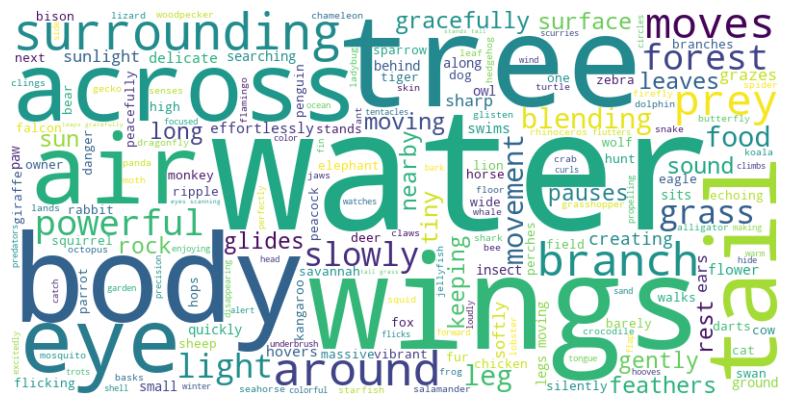

In [29]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(data_ner['Text']))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [35]:
vlabels, count = data_ner['Label'].value_counts().index, data_ner['Label'].value_counts().values
np.unique(count)

array([5, 6])

As we see, labels distribution is balanced.

### Define part of speech of each word and labels of the animals

In [41]:
nlp = spacy.load("en_core_web_sm")

In [53]:
token_data = []
animals = data_ner['Label'].unique()

for index, row in data_ner.iterrows():
    doc = nlp(row["Text"])

    sentence_id = index + 1
    printed_tokens = set()

    for token_index, token in enumerate(doc):
        label = "O"

        for animal in animals:
            if animal.strip().lower() in token.text.lower():
                label = "ANIMAL"
                break

        if token.text not in printed_tokens:
            token_data.append({
                "sentence_id": sentence_id,
                "word": token.text,
                "POS": token.pos_,
                "label": label
            })
            printed_tokens.add(token.text)

In [54]:
tokens_df = pd.DataFrame(token_data)
tokens_df.head(100)

,sentence_id,word,POS,label
0,1,The,DET,O
1,1,cat,NOUN,ANIMAL
2,1,is,AUX,O
3,1,napping,VERB,O
4,1,peacefully,ADV,O
...,...,...,...,...
95,9,water,NOUN,O
96,9,from,ADP,O
97,9,the,DET,O
98,9,river,NOUN,O


Now let's check distribution in labels.

In [55]:
tokens_df['label'].value_counts()

label
O         4185
ANIMAL     362
Name: count, dtype: int64

We see that there is some imblance, but it is not a problem. Let's save our data.

In [57]:
tokens_df.to_csv('data/NER_data/test_task_NER_dataset.csv', index=False, encoding='utf-8')